In [60]:
!pip install mplfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [34]:
# Tentukan simbol saham dan rentang tanggal
symbol = "TLKM.JK"
start_date = "2014-07-01"
end_date = "2024-07-01"

# Dapatkan data saham menggunakan yfinance
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Simpan data ke file CSV jika diinginkan
stock_data.to_csv("TLKM.csv")

[*********************100%%**********************]  1 of 1 completed


In [35]:
# Import Data
df = pd.read_csv("TLKM.csv", parse_dates=True, index_col='Date')
print(df.head())

              Open    High     Low   Close    Adj Close     Volume
Date                                                              
2014-07-01  2480.0  2480.0  2465.0  2480.0  1838.371826   46366400
2014-07-02  2500.0  2500.0  2475.0  2500.0  1853.197510   44555300
2014-07-03  2475.0  2515.0  2465.0  2475.0  1834.665405   72541800
2014-07-04  2525.0  2540.0  2475.0  2525.0  1871.729370   96433200
2014-07-07  2600.0  2600.0  2530.0  2600.0  1927.325073  225720400


In [36]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-01,2480.0,2480.0,2465.0,2480.0,1838.371826,46366400
2014-07-02,2500.0,2500.0,2475.0,2500.0,1853.197510,44555300
2014-07-03,2475.0,2515.0,2465.0,2475.0,1834.665405,72541800
2014-07-04,2525.0,2540.0,2475.0,2525.0,1871.729370,96433200
2014-07-07,2600.0,2600.0,2530.0,2600.0,1927.325073,225720400


In [37]:
# Tambahkan kolom 'Name' dengan nilai 'TLKM'
df['Name'] = 'TLKM'

In [38]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2.471000e+03
mean,3677.199514,3715.457305,3638.615945,3676.560097,3000.052636,9.895601e+07
std,556.561967,558.195793,553.664610,557.282432,558.812846,6.635408e+07
min,2475.000000,2480.000000,2450.000000,2475.000000,1834.665405,0.000000e+00
25%,3220.000000,3270.000000,3172.500000,3220.000000,2623.885010,6.107990e+07
50%,3790.000000,3820.000000,3750.000000,3780.000000,3003.241943,8.443660e+07
75%,4090.000000,4150.000000,4050.000000,4090.000000,3428.768066,1.173586e+08
max,4850.000000,4850.000000,4780.000000,4800.000000,4295.701172,1.155861e+09


In [39]:
# Cek Missing Value
print(df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64


In [43]:
# Cek duplikat data
print(df.duplicated().any())

True


In [44]:
# Mengambil kolom 'Close' sebagai data pelatihan
dataTrain = df['Close'].values.reshape(-1, 1)

In [45]:
# Membuat objek MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# Melakukan transformasi pada dataTrain
dataTrain_scaled = sc.fit_transform(dataTrain)

In [46]:
# Membagi dataTrain yang sudah di scaling menjadi Input Time Series, dan Output
x_train = []
y_train = []
for i in range(120, len(dataTrain_scaled)):
    x_train.append(dataTrain_scaled[i-120:i, 0])
    y_train.append(dataTrain_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [47]:
# Melakukan reshaping pada x_train menjadi 3 dimensi yang akan digunakan sebagai input dari RNN
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
# Membagi data menjadi 80% untuk pelatihan dan 20% untuk pengujian
train_size = int(len(dataTrain_scaled) * 0.8)
x_train, x_test = x_train[:train_size], x_train[train_size:]
y_train, y_test = y_train[:train_size], y_train[train_size:]

In [16]:
regressor = Sequential()
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=64))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

In [17]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 120, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 120, 64)           33024     
                                                                 
 dropout_2 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120, 64)           3

In [18]:
regressor.compile(optimizer="adam",loss="mean_squared_error")

In [19]:
regressor.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
62/62 [==============================] - 33s 385ms/step - loss: 0.0318
Epoch 2/50
62/62 [==============================] - 22s 349ms/step - loss: 0.0095
Epoch 3/50
62/62 [==============================] - 26s 419ms/step - loss: 0.0089
Epoch 4/50
62/62 [==============================] - 20s 323ms/step - loss: 0.0081
Epoch 5/50
62/62 [==============================] - 22s 352ms/step - loss: 0.0073
Epoch 6/50
62/62 [==============================] - 19s 302ms/step - loss: 0.0069
Epoch 7/50
62/62 [==============================] - 21s 339ms/step - loss: 0.0065
Epoch 8/50
62/62 [==============================] - 19s 314ms/step - loss: 0.0064
Epoch 9/50
62/62 [==============================] - 19s 312ms/step - loss: 0.0060
Epoch 10/50
62/62 [==============================] - 19s 298ms/step - loss: 0.0062
Epoch 11/50
62/62 [==============================] - 18s 296ms/step - loss: 0.0052
Epoch 12/50
62/62 [==============================] - 20s 315ms/step - loss: 0.0050
Epoch 13/50
6

In [20]:
predictions = regressor.predict(x_test)
predictions = sc.inverse_transform(predictions)

12/12 [==============================] - 4s 77ms/step


In [21]:
# Menghitung Mean Squared Error (MSE)
mse = mean_squared_error(sc.inverse_transform(y_test.reshape(-1, 1)), predictions)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 5049.710406265098


In [48]:
# Membuat DataFrame untuk hasil prediksi dan nilai asli
test_dates = df.index[-len(y_test):]  # Mendapatkan tanggal untuk data uji

In [49]:
# Memastikan bahwa tanggal dalam DataFrame sesuai dengan data uji
results = pd.DataFrame({'Date': test_dates, 'Actual': sc.inverse_transform(y_test.reshape(-1, 1)).flatten(), 'Prediction': predictions.flatten()})

In [50]:
# Konversi kolom Date menjadi tipe datetime
results['Date'] = pd.to_datetime(results['Date'])

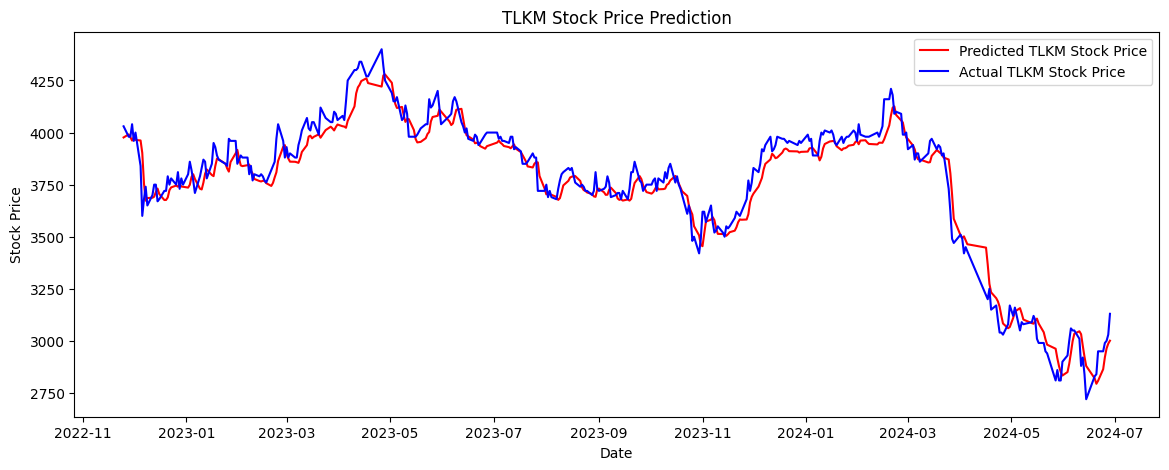

In [51]:
# Visualisasi hasil prediksi untuk semua data uji
plt.figure(figsize=(14, 5))
plt.plot(results['Date'], results['Prediction'], color='red', label='Predicted TLKM Stock Price')
plt.plot(results['Date'], results['Actual'], color='blue', label='Actual TLKM Stock Price')
plt.title('TLKM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [52]:
filtered_results = results[(results['Date'].dt.year == 2024) & (results['Date'].dt.month == 6)]


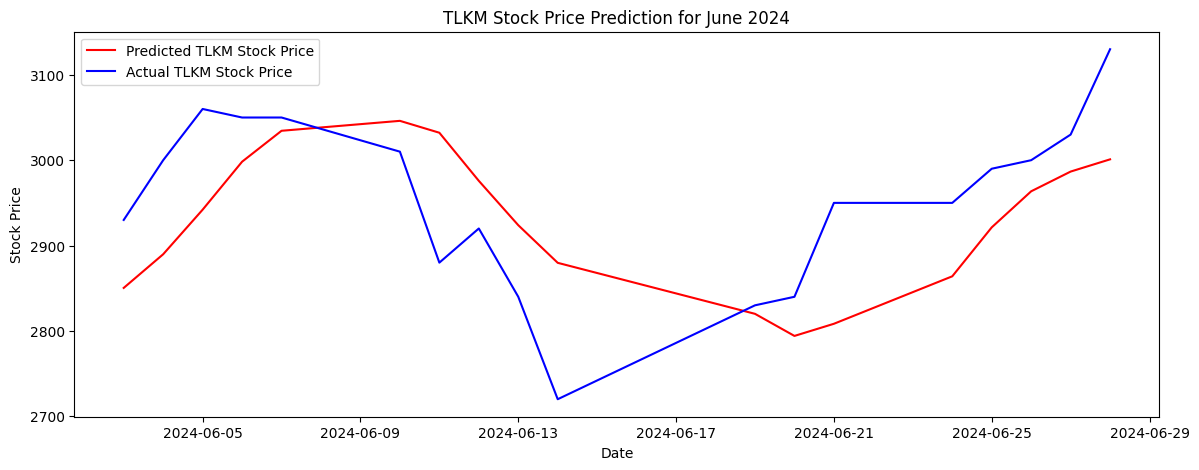

In [53]:
# Pastikan filtered_results tidak kosong sebelum plotting
if not filtered_results.empty:
    # Visualisasi hasil prediksi untuk bulan tertentu
    plt.figure(figsize=(14, 5))
    plt.plot(filtered_results['Date'], filtered_results['Prediction'], color='red', label='Predicted TLKM Stock Price')
    plt.plot(filtered_results['Date'], filtered_results['Actual'], color='blue', label='Actual TLKM Stock Price')
    plt.title('TLKM Stock Price Prediction for June 2024')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
else:
    print("No data available for the selected month and year.")

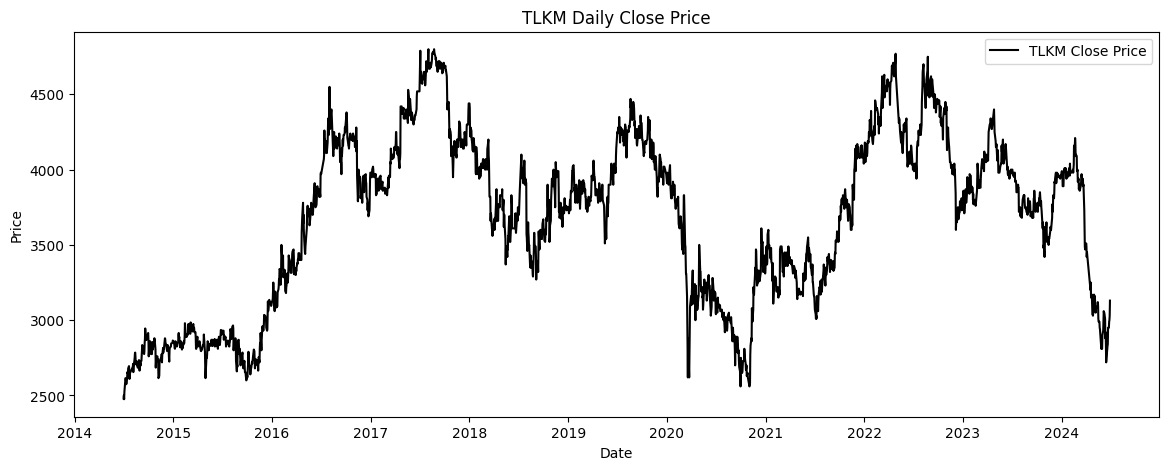

In [54]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], color='black', label='TLKM Close Price')
plt.title('TLKM Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


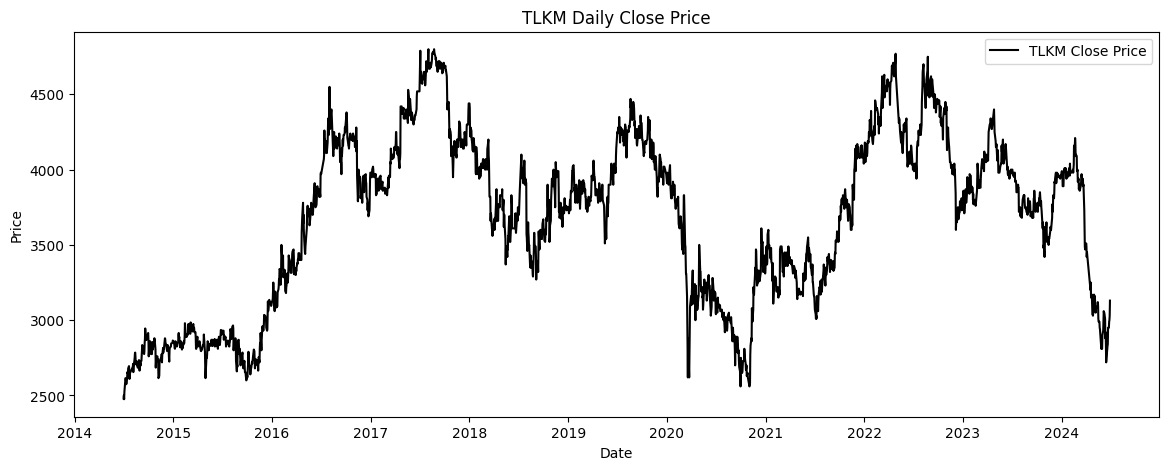

In [55]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], color='black', label='TLKM Close Price')
plt.title('TLKM Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


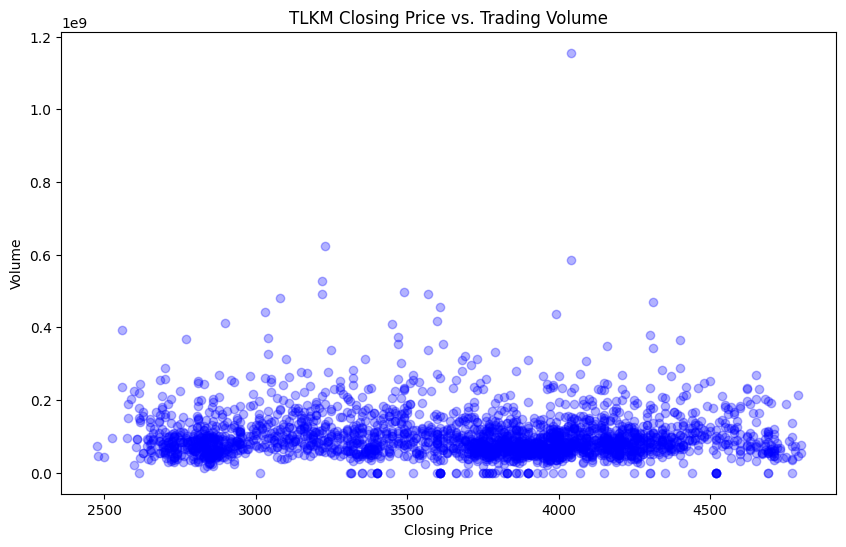

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Close'], df['Volume'], color='blue', alpha=0.3)
plt.title('TLKM Closing Price vs. Trading Volume')
plt.xlabel('Closing Price')
plt.ylabel('Volume')
plt.show()


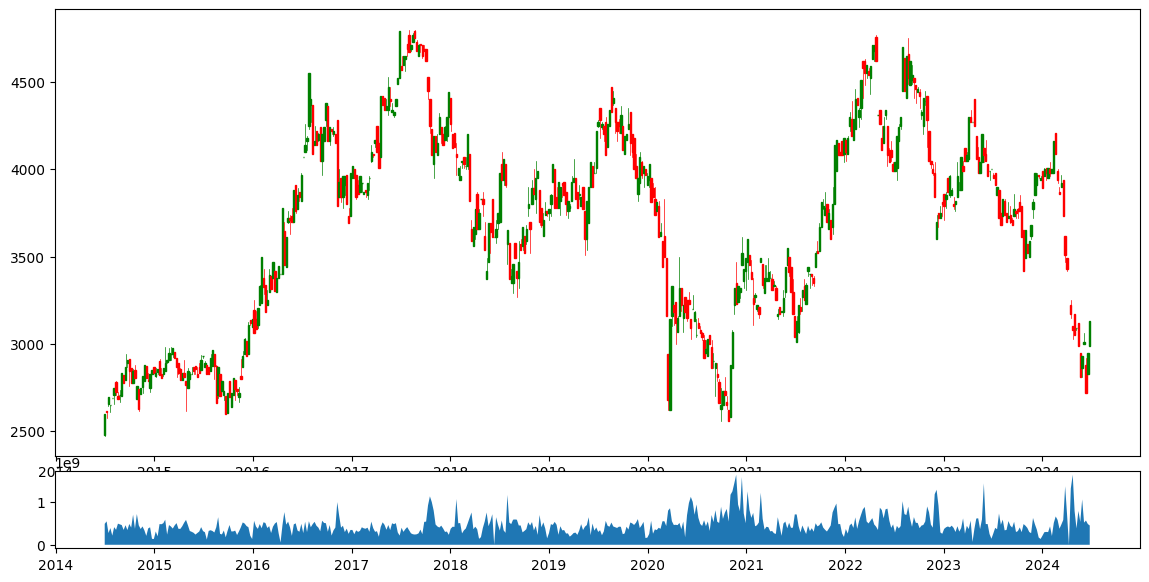

In [61]:
df_ohlc = df['Close'].resample('7D').ohlc()
df_volume = df['Volume'].resample('7D').sum()

df_ohlc.reset_index(inplace=True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

plt.figure(figsize=(14, 7))
ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=5, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)
plt.show()